# Amazon SageMaker XGBoost를 이용한 은행거래 사기 탐지

미국에서는 매년 수십억건의 은행 거래가 발생합니다. 이 중 매우 소수가 사기(Fraud)와 관리되지만 만약 그 거래가 잘 탐지되지 않았을 때 피해는 매우 큽니다. 피해 비용은 고객과 기업의 손실, 그리고 거래의 유효성을 확인해야 하는 금융 규제기관에 이르기까지 막대합니다. 

## 사기 탐지
오늘 우리의 작업은 자동으로 사기 거래를 탐지하는 시스템을 설계하는 것입니다. 제공된 레이블 데이터를 사용하여 다양한 접근을 시도해 보십시오. 우리가 해결해야 하는 문제는 정확한 분류를 위한 모델일 수도 있고 가장 의심스러운 거래를 찾아내는 모델이 될 수도 있고 또는 이런 모델들의 조합일 수도 있습니다. 

## 사용할 데이터
Kaggle 계정을 생성하고 아래 링크를 통해서 데이터를 다운로드하십시오. (빠른 실습을 위해서 data 폴더의 파일을 사용하실 수 있습니다.)
* https://www.kaggle.com/ntnu-testimon/paysim1 


## Classifiers
### 분류하기

데이터는 하나의 파일로 제공됩니다. 여러분은 이 파일을 학습셋, 테스트셋, 검증셋으로 나누어야 할 것입니다. 모델을 최적화 할 때 검증 세트를 이용하시고, 모델에 대한 최종 보고서를 작성해야 할 경우 테스트셋을 별도로 분리하십시오. 

최초접근으로 SageMaker의 빌트인 알고리즘인 XGBoost를 권장합니다.

## Feature Engineering

Feature engineering을 위해 다음 단계를 고려하십시오. 
- 원핫인코딩(one hot encoding)을 통하여 명목형(categorical) 문자 변수를 모델에서 사용할 수 있는 형태로 변형하십시오.
- sci kit learn의 min-max scaler를 이용하여 숫자형 컬럼의 스케일을 조정하십시오.
- Feature를 선정하고 조정해 갑니다. 시간 정보(timestep)가 의미있는 정보를 가지나요? 특정 Feature와 다른 Feature의 연산결과가 목표변수와 연관성을 가질까요?

## 솔루션 확장하기 (고급)

XGBoost로 어느 정도 의미있는 결과를 도출했다면, 이를 확장하여 다른 모델을 만들어 봅니다. Linear Learner와 KNN을 이용한 분류를 적용해 보십시오. 

아래의 참조코드를 이용하여 여러 모델을 병렬로 학습해 보십시오. 클라우드에서 멀티쓰레드 방식으로 실행하면 다음 실험을 시작하기 전에 이전 실험이 끝나기를 기다릴 필요가 없습니다.

결과를 분석할 때 각 모델에 대하여 두 개의 엔드포인트를 생성하고 모두에게 데이터를 보내 보십시오. 실행결과를 취합한 후 최대 예측값을 찾아보고 recall을 구해봅니다. XGBoost로 실행한 처음 시도에 비해서 결과가 좋아졌나요?


## 참조 코드
다음 XGBoost 예제를 참고하십시오. (SageMaker 공식 예제에 대한 한글 번역입니다.) 
- https://github.com/mullue/xgboost  
    - 0.xgboost simple - XGBoost를 이용한 모델개발의 기본 코드를 이해하는 용도입니다.
    - 1.xgboost direct marketing - SageMaker를 처음 실행하시는 분들을 위한 참조코드입니다.
    - 2.multiprocess ensembler - 앙상블을 이용하는 심화 예제입니다.

또는 다음 코드를 참고하실 수도 있습니다. (영문) 
- https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb 
- 본 github repository의 starter-code 폴더에 있는 [Multiprocess Ensembler.ipynb](../Starter-Code/Multiprocess%20Ensembler.ipynb)

  
# References

시뮬레이션 데이터셋에 대해 설명 Paper 
* https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION/download  

In [1]:
# !pip install -U sagemaker

In [3]:
import sagemaker
sagemaker.__version__

'2.25.2'

In [4]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
prefix = 'sagemaker/DEMO-xgboost-dm'           # prefix used for all data stored within the bucket


# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

분석과정에서 필요한 파이썬 라이브러리를 로드합니다.

In [5]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
# from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

---

### 데이터
[direct marketing dataset](https://www.kaggle.com/ntnu-testimon/paysim1) 데이터를 다운로드합니다.

### Kaggle 데이터셋 다운로드 방법
[how to dowload kaggle dataset](download_kaggle_dataset-copy.ipynb) download_kagge_dataset.ipynb 참고<br>
/data/PS_20174392719_1491204439457_log.csv 다운로드 되어 있음




pandas 데이터프레임으로 로드하고 내용을 살펴봅니다.

In [6]:
data = pd.read_csv('/root/project/xgboost-bank-fraud/data/PS_20174392719_1491204439457_log.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
train_data, validation_data, eda_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%
eda_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
649918,35,CASH_IN,132520.80,C882640384,11508.00,144028.80,C900082294,0.00,0.00,0,0
6078014,518,PAYMENT,5927.64,C2051460816,58852.27,52924.63,M1317983785,0.00,0.00,0,0
3352247,253,CASH_OUT,2899.46,C1164635243,6054.00,3154.54,C2081989200,964608.59,967508.05,0,0
2875453,227,CASH_OUT,193469.02,C948444834,0.00,0.00,C320833069,248357.55,441826.56,0,0
5729113,399,CASH_OUT,93088.86,C64141112,107246.00,14157.14,C2015035419,0.00,93088.86,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1158526,131,CASH_IN,20521.68,C454408636,18775689.84,18796211.52,C798046321,452543.32,432021.63,0,0
1234469,134,CASH_OUT,546087.15,C247527808,646768.77,100681.62,C977895157,2528736.09,3329246.86,0,0
5178611,359,CASH_IN,148431.15,C2048189824,16658079.72,16806510.87,C1744591251,379530.34,231099.19,0,0
6360166,715,CASH_OUT,72610.82,C188298838,4559.00,0.00,C528830442,0.00,72610.82,0,0


11개의 컬럼으로 6백만건의 레코드를 가지는 192MB의 데이터입니다. 이 데이터셋은 금융 응용프로그램의 연구를 돕기 위한 시뮬레이션 데이터셋입니다. 각 레코드는 하나의 거래를 의미하며 입금(cash in), 출금(cash out), 직불(debit), 신용(credit), 또는 송금(transfer)을 나타냅니다. 각 거래는 금액과 거래주체(name of origin) 등을 가집니다. 여러분은 2개의 목표 컬럼을 가집니다. 하나는 사기여부를 나타내는 isFraud이며 수작업으로 레이블된 값입니다. 다른 하나는 룰 기반으로 세팅된 값이며 200,000 이상의 값을 가지는 거래를 표시합니다. 대부분의 금융회사에서 룰기반 시스템을 운용하고 있으며, 복잡하고 거대한 룰엔진 시스템으로부터 머신러닝 시스템의 사용을 검토하는 것은 매우 일반적입니다. 

![alt text](Images/rcf_datahead.png "rcf_datahead")

컬럼들의 의미는 다음과 같습니다.
- step : 시간단위. 1 Step은 1 시간을 의미함. 
- type : 거래 유형 (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
- amount : 거래 금액
- nameOrig : 거래를 시작한 주체
- oldbalanceOrg : 거래 시작 주체의 거래 이전 잔고
- newbalanceOrig : 거래 시작 주체의 거래 이후 잔고
- nameDest : 거래 대상 주체
- oldbalanceDest : 거래 대상의 거래 이전 잔고
- newbalanceDest : 거래 대상의 거래 이후 잔고
- isFraud : 사기 여부 
- isFlaggedFraud : 룰시스템의 판단 결과

### 탐험
데이터 탐험(EDA)를 해봅니다. 첫번째로 속성의 분포를 살펴봅니다. 

col_0,% observations
type,
CASH_IN,0.220095
CASH_OUT,0.351516
DEBIT,0.006368
PAYMENT,0.338511
TRANSFER,0.083510


col_0,% observations
nameOrig,
C1000009272,0.000002
C1000016582,0.000002
C1000021747,0.000002
C100002506,0.000002
C1000037502,0.000002
...,...
C999988718,0.000002
C999988902,0.000002
C999989611,0.000002


col_0,% observations
nameDest,
C1000004940,0.000002
C1000013769,0.000005
C100001587,0.000002
C1000015936,0.000003
C1000022185,0.000002
...,...
M999944493,0.000002
M999946429,0.000002
M999954313,0.000002


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,636262.000000,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.000000
mean,243.312192,1.790923e+05,8.303416e+05,8.513510e+05,1.089740e+06,1.212764e+06,0.001300,0.000002
std,142.250532,5.809614e+05,2.874986e+06,2.910899e+06,3.331188e+06,3.593801e+06,0.036029,0.001254
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,156.000000,1.340601e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,239.000000,7.461216e+04,1.445650e+04,0.000000e+00,1.325915e+05,2.137816e+05,0.000000,0.000000
75%,334.000000,2.083795e+05,1.071439e+05,1.440011e+05,9.384428e+05,1.107410e+06,0.000000,0.000000
max,743.000000,5.132412e+07,3.958504e+07,3.856340e+07,3.560159e+08,3.561793e+08,1.000000,1.000000


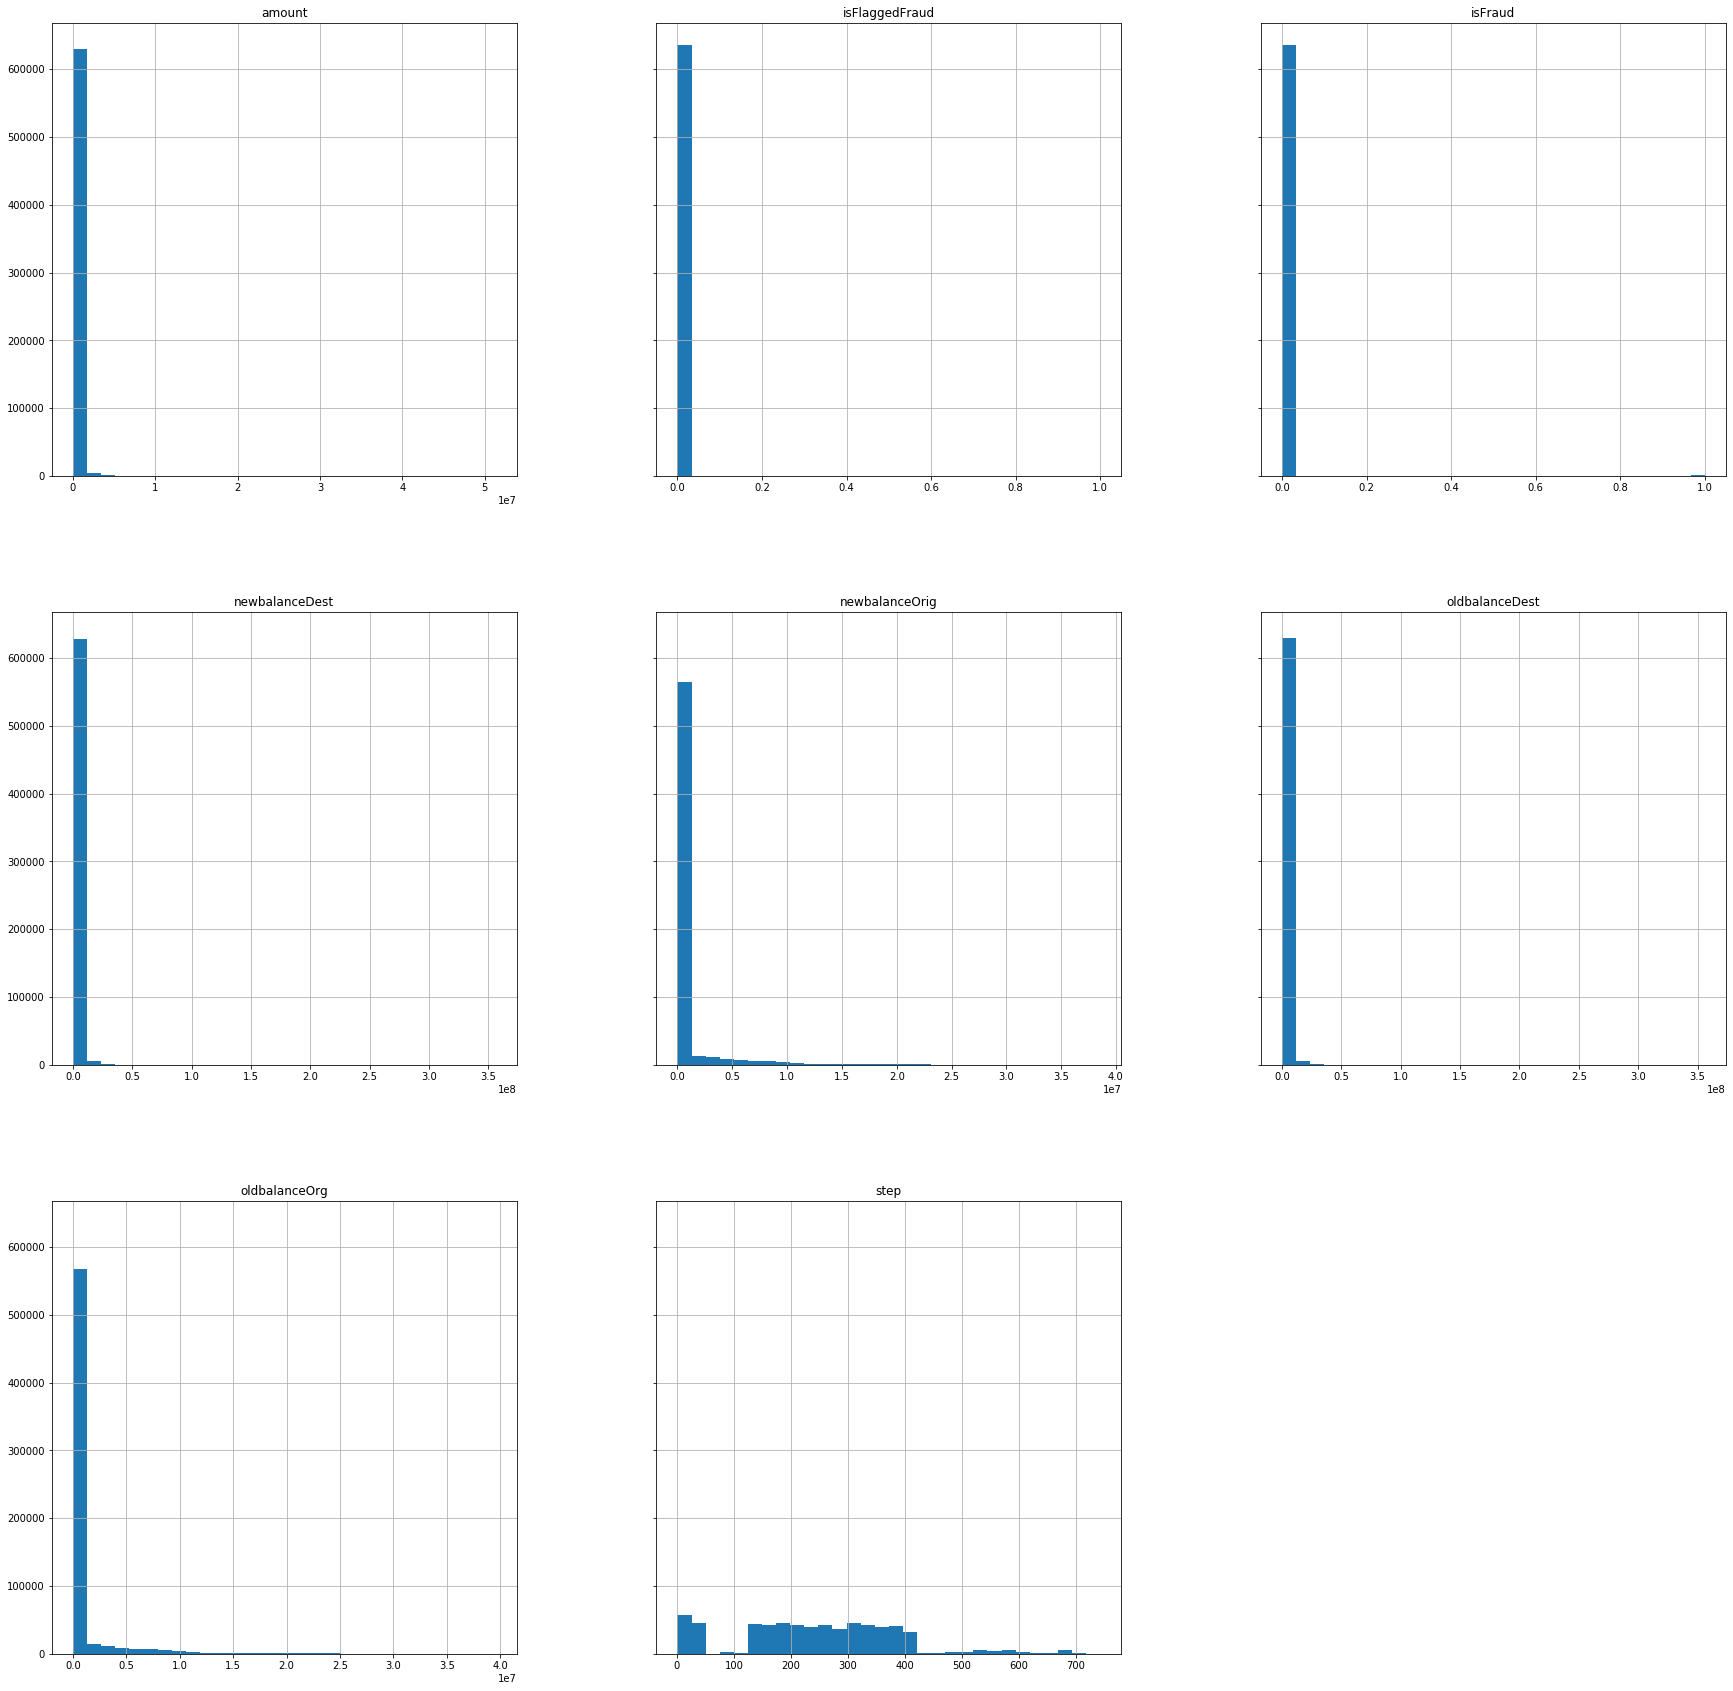

In [7]:
# Frequency tables for each categorical feature
for column in eda_data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=eda_data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(eda_data.describe())
%matplotlib inline
hist = eda_data.hist(bins=30, sharey=True, figsize=(30, 30))

다음을 생각해 볼 수 있습니다.:

* Step 에 수와 IsFraud 의 관계는? X
* Amount 크기와 IsFraud 의 관계는? 거래가 작을수록 Fraud 확률이 높음
* nameOrig, nameDest는 IsFraud와 관계를 찾기 쉽지 않음 
* newbalanceOrg - oldbalanceOrg  차와 IsFraud 의 관계는? 잔고차이가 적을수록 Fraud 확률이 낮음
* newbalanceDest - oldbalanceDest 차와 IsFraud 의 관계는? 잔고차이가 적을수록 Fraud 확률이 높음
* isFlaggedFraud 와  IsFraud 의 관계는?

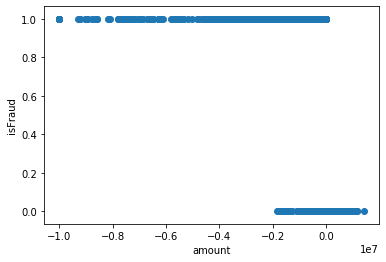

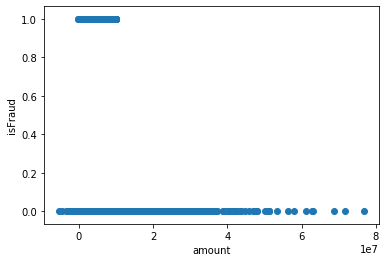

isFraud,0,1
isFlaggedFraud,,
0,1.0,0.998052
1,0.0,0.001948


In [8]:
plt.scatter(eda_data['newbalanceOrig']-eda_data['oldbalanceOrg'],eda_data['isFraud'])
plt.xlabel('amount')
plt.ylabel('isFraud')
plt.show()


plt.scatter(eda_data['newbalanceDest']-eda_data['oldbalanceDest'],eda_data['isFraud'])
plt.xlabel('amount')
plt.ylabel('isFraud')
plt.show()

display(pd.crosstab(index=data['isFlaggedFraud'], columns=data['isFraud'], normalize='columns'))

Notice that:
다음을 확인할 수 있습니다.

* 속성간 상호 연관성은 다양합니다. 일부는 매우 음의 상관관계를, 또 다른 일부는 양의 상관관계를 보여줍니다. 
* 속성간의 관계는 대부분 비선형이며, 연관성이 크지 않습니다.

### 변형

데이터 클린징은 대부분의 머신러닝 프로젝트에서 필요한 작업입니다. 이 작업은 적절히 수행되지 않으면 결과에 악영향을 끼치며, 주관적인 판단이 많이 개입됩니다. 몇가지 일반적인 기술들은 다음과 같습니다.

* 결측치의 처리 : 일부 머신러닝 알고리즘은 결측치를 처리할 수 있는 경우도 있지만 대부분은 그렇지 않습니다. 이를 처리하는 옵션은:
    * 결측값 제거 : 결측값이 매우 일부분일 경우 적용합니다.
    * 결측속성 제거 : 다량의 결측값을 가지는 속성이 일부분일 경우 적용합니다.
    * 결측값 채우기(imputing) : 다음 책[books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) 전체에서 이 주제에 대해 다루고 있습니다. 일반적인 선택은 결측값을 해당 속성의 다른 값들의 평균이나 최빈값(mode)으로 대체하는 것입니다.
* 명목형(categorical) 속성을 수치형 속성으로 변환 : 가장 일반적인 방법은 원 핫 인코딩(one hot encoding)이라 불리는, 각 명목값들을 컬럼으로 정의한 후 해당값에 매칭되는 여부에 따라 1 또는 0의 값을 가지도록 변환하는 것입니다.
* 분포가 고르지 않은 데이터 : Gradient Boosted Trees와 같은 비선형 모델에서도 좋지 않은 영향을 가져오며, 회기(regression)와 같은 파라미터 방식에서도 과도하게 편향된 데이터는 정확도가 떨어지는 결과를 리턴할 수 있습니다. 간혹 로그(log)값을 취하는 것으로 충분히 정규분포로 변환하는 경우도 있고 개별 범위로 구분하여 명목형 번수로 변환한 후 다시 원 핫 인코딩으로 적용할 수도 있습니다.
* 보다 복잡한 데이터 타입 처리 : 본 노트북에서 다루지는 않지만 이미지, 텍스트, 또는 다양한 grain을 가지는 데이터들에 대해서도 추가 변형이 필요합니다. 

다행히 이들 중 일부는 이미 처리되어 있습니다. 그리고 지금 우리가 다루려고 하는 알고리즘은 드문드문하거나(sparce) 분포가 일정하지 않은 경우에도 잘 동작하는 경향이 있습니다. 따라서 본 예제에서는 최소한의 전처리만 하겠습니다.


In [9]:
data['balanceOrgGap'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['balanceDestGap'] = data['newbalanceDest'] - data['oldbalanceDest']

model_data = data.drop(['nameOrig', 'nameDest'], axis=1)
model_data = pd.get_dummies(model_data) 

# Convert categorical variables to sets of indicators
model_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceOrgGap,balanceDestGap,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,-9839.64,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,0,0,0,1,0


모델을 만들기 전에 필요한 또 다른 질문은 특정 속성이 최종 목표에 기여를 하는지 여부입니다. 예를 들어, 최선의 예측을 제공하는 것이 목표인 경우, 예측을 하려는 시점에 해당 데이터를 사용가능한 지 생각해 봅니다. 우산 판매의 예측에서 비가 올지 여부를 안다면 판매예측에서 매우 유리할 것이지만, 미래의 날씨를 예측하는 것은 날씨 정보 없이 우산판매를 예측하는 것보다 더 어려울 수 있습니다. 이런 경우 과거 날씨정보가 모델의 속성에 포함된다면 정확성을 왜곡할 수도 있습니다. 

이런 논리로, 데이터의 속성들 중 미래에 대한 예측이 필요한 경제 지표들과 `duration`부분을 제외하겠습니다.

이전 분기의 경제 지표 값을 사용할 수도 있겠지만, 이 값들은 실제 업무환경에서는 현실성이 없을 가능성이 높습니다.

모델을 만들 때 1차적인 목표는 새로운 데이터에 대한 타겟변수 값을 예측하는 것이며, 이 때 과적합(overfitting)을 이해하는 것이 중요합니다. 지도학습(Supervised learning) 모델은 타겟변수 값에 대한 실제값과 모델의 예측값 사이의 차이(error)를 최소하는 방식으로 설계됩니다. 이 마지막 부분이 중요합니다. 종종 머신러닝 모델은 보다 높은 정확도를 찾는 과정에서 자신이 본 데이터들만에 대한 사소한 특징들까지 고려하는 편중(bias)를 가지게 됩니다. 이런 특징이 새로운 데이터에서 반복적으로 나타나지 않을 경우 실제 예측에서는 정확도가 떨어지게 되고 학습과정에서의 정확도 수준을 보이지 않게 됩니다.   

이를 예방하는 가장 일반적인 방법은 모델이 학습을 할 때 학습데이터 뿐 아니라 새로운 데이터에 대해서도 적합성을 함께 판단하도록 하는 것이며 홀드아웃 검증(holdout validation), 교차검증(cross-validation), 일회성 검증(leave-one-out validation) 등 여러가지 방식이 있습니다. 본 예제에서는 단순히 랜덤하게 3개의 그룹으로 데이터를 나눌 것입니다. 모델은 70%의 데이터를 이용하여 학습을 하고, 20%의 데이터를 새로운 데이터에대한 정확도를 평가하는 용도로 사용하고, 10%의 데이터를 마지막 테스트셋으로 분리하여 성능을 테스트하겠습니다. 또한 데이터셋 분리시 랜덤하게 순서를 조정하고 있음에도 주목합니다.


In [10]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMaker의 XGBoost 컨테이너는 libSVM 또는 CSV 포맷의 데이터를 사용합니다. 본 예제에서는 CSV를 이용합니다. CSV파일에서 첫번째 컬럼을 타겟변수 값으로 지정해야 하며 헤더를 포함하고 있지 않아야 합니다. 본 예제에서는 데이터를 train|validation|test 데이터셋으로 분리한 후 작업을 하고 있습니다. 

In [11]:
pd.concat([train_data['isFraud'], train_data.drop(['isFraud'], axis=1)], axis=1).to_csv('./data/train.csv', index=False, header=False)
pd.concat([validation_data['isFraud'], validation_data.drop(['isFraud'], axis=1)], axis=1).to_csv('./data/validation.csv', index=False, header=False)
pd.concat([test_data['isFraud'], test_data.drop(['isFraud'], axis=1)], axis=1).to_csv('./data/test.csv', index=False, header=False)
pd.concat([test_data.drop(['isFraud'], axis=1)], axis=1).to_csv('./data/test_features.csv', index=False, header=False)


다음은 SageMaker의 관리형 학습환경에서 이 데이터에 접근할 수 있도록 파일을 S3로 복사하겠습니다.

In [12]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('./data/train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('./data/validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('./data/test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test_features.csv')).upload_file('./data/test_features.csv')


---

## 학습

우리가 사용하는 데이터의 많은 속성들이 편향된 분포를 가지고 있습니다. 일부 속성들은 서로 높은 연관성을 가지고 있고 일부는 타겟속성 값과 비선형 관계를 가지고 있었습니다. 또한 미래 마케팅에 대한 예측에서 높은 정확도가 필요하고 왜 그렇게 판단하는지에 대한 설명 또한 중요합니다. 이런 점들을 고려할 때 Gradient boosted tree와 같은 알고리즘이 매우 적합한 후보입니다. 

Gradient boosted tree는 작은 모델들이 결합되어 작동하며, 각 모델은 이전 모델의 결함을 보완하는 방식으로 동작합니다. 단순한 모델들이 모여 크고 복잡한 다른 모델들보다 높은 성능을 냅니다. Gradient boosting tree알고리즘이 다른 알고리즘과 어떻게 다른지에 대해 설명하는 다른 SageMaker 노트북이 있으니 이를 참고합니다.

`xgboost`는 매우 인기있는 Gradient bossted tree에 대한 오픈소스 패키지 입니다. 계산성능이 뛰어나고, 필요한 기능들을 모두 구현하고 있으며, 많은 머신러닝 경쟁에서 성공적인 성과를 보여주고 있습니다. SageMaker의 관리형, 분산 학습 프레임워크를 이용하여 학습할 수 있도록 간단한 `xgboost`모델을 시작해 보겠습니다. 

먼저, SageMaker의 XGBoost구현체가 있는 ECR 컨터이너를 지정합니다.

In [13]:
from sagemaker import image_uris 
container = image_uris.retrieve('xgboost', region='ap-northeast-2', version='latest')

우리는 CSV 파일 포맷을 사용하므로 S3의 파일 위치를 알려주는 `s3_input`오브젝트를 생성하고 콘텐츠 타입을 CSV로 지정합니다.

In [14]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')


다음으로 다음 파라미터를 지정하여 esitmator를 생성합니다.

1. `xgboost` 알고리즘 컨테이너를 사용
1. 사용할 IAM 역할(role)
1. 학습용 인스턴스 타입과 수량 
1. 출력데이터를 위한 S3위치 
1. 알고리즘 하이퍼파라미터 

이제 다음 파라미터를 이용하여 `.fit()` 명령을 실행합니다.
1. 학습용 데이터가 있는 S3 위치. 본 예제는 학습과 검증 데이터셋을 모두 사용하므로 두 채널을 모두 지정합니다.


In [15]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-03-04 04:02:18 Starting - Starting the training job...
2021-03-04 04:02:44 Starting - Launching requested ML instancesProfilerReport-1614830538: InProgress
......
2021-03-04 04:03:47 Starting - Preparing the instances for training......
2021-03-04 04:04:46 Downloading - Downloading input data...
2021-03-04 04:05:11 Training - Downloading the training image..Arguments: train
[2021-03-04:04:05:32:INFO] Running standalone xgboost training.
[2021-03-04:04:05:32:INFO] File size need to be processed in the node: 424.35mb. Available memory size in the node: 8412.94mb
[2021-03-04:04:05:32:INFO] Determined delimiter of CSV input is ','
[04:05:32] S3DistributionType set as FullyReplicated
[04:05:34] 4453834x14 matrix with 62353676 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-03-04:04:05:34:INFO] Determined delimiter of CSV input is ','
[04:05:34] S3DistributionType set as FullyReplicated
[04:05:35] 1272524x14 matrix with 17815336 entries loaded fr

---

## 호스팅

입력데이터에 대해 `xgboost` 모델의 학습이 완료되면 이 모델을 실시간 추론을 위한 엔드포인트로 배포하겠습니다.

In [16]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------------!

---

## 평가

머신러닝 모델의 성능을 확인하는 여러가지 방법이 있습니다. 여기서는 단순히 실제값과 예측값을 비교하겠습니다. 정기예금에 가입을 한 경우(`1`) 와 그렇지 않은 경우(`0`)를 이용하여 혼돈행렬(confusion matrix)를 생성하겠습니다.

이를 위해 추론용 데이터를 엔드포인트에 전달하고 결과를 받아야 합니다. 현재 데이터는 노트북 인스턴스의 메모리에 NumPy 배열로 저장되어 있습니다. 데이터를 HTTP POST request로 보내기 위해 CSV형태로 직렬화(serialize)하고 결과로 리턴되는 CSV를 디코딩합니다.

*주의: SageMaker XGBoost에서 CSV포맷으로 추론할 때 요청 데이터는 타겟속성 컬럼을 포함하지 않습니다.*

In [17]:
from sagemaker.serializers import CSVSerializer
xgb_predictor.serializer = CSVSerializer()

엔드포인트를 호출하는 간단한 함수를 생성합니다.:

1. 테스트 데이터셋을 반복(Loop)
1. rows 만큼 미니매치로 나누기
1. 미니배치를 CSV string payloads로 변환 (타겟속성 변수를 제거합니다.)
1. XGBoost 엔드포인트를 호출하고 예측값 수신
1. CSV결과로 리턴된 예측값을 다시 NumPy 배열로 변환


In [18]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['isFraud'], axis=1).to_numpy())

예측결과와 실제값을 비교하는 혼돈행렬을 생성합니다.

In [19]:
pd.crosstab(index=test_data['isFraud'], columns=np.round(predictions), rownames=['isFraud'], colnames=['isFraud'])

isFraud,0.0,1.0
isFraud,,
0.0,635584,0
1.0,0,678


* 결과 확인필요

---

## 확장

본 예제는 비교적 작은 데이터셋을 이용한 분석이지만 SageMaer의 분산, 관리형 학습과 실시간 모델 호스팅 기능은 대량의 데이터를 다루어야 하는 문제에도 쉽게 적용될 수 있습니다. 예측 정확도를 더 개선하기 위해 false-positives와 false-negatives에 변화를 주도록 threshold값을 조정할 수 있습니다. 실제 업무환경에서는 데이터의 속성을 보다 면밀히 살피고, 현재 데이터셋에서 추가로 더 많은 고객정보를 확보하기 위해 더 많은 시간을 소비하게 될 것입니다..

### (옵션) 리소스 제거

본 예제를 모두 마무리한 후 아래 셀을 실행합니다. 다음 명령은 추론 단계에서 생성한 SageMaker에서 호스팅되고 있는 엔드포인트를 제거합니다. 엔드포인트를 삭제하지 않으면 계속 사용요금이 발생할 수 있습니다.


In [20]:
xgb_predictor.delete_endpoint()